<a href="https://colab.research.google.com/github/mohamed10122001/Hate-Speech-Detection/blob/main/HateSpeechDetectionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Detection**

## **Introduction**
Avec l'essor des réseaux sociaux et des plateformes de communication en ligne, la diffusion de discours haineux est devenue une préoccupation majeure. Ce type de contenu, qui inclut des propos insultants, discriminatoires ou incitant à la haine envers certains groupes ou individus, peut nuire gravement au bien-être des utilisateurs et à la cohésion sociale. La détection automatique du discours haineux est donc devenue un enjeu essentiel pour garantir un environnement en ligne plus sûr.

## Importation des bibliothèques necessaires

In [ ]:
!pip install transformers
!pip install evaluate
!pip install gradio

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from pathlib import Path

from collections import Counter
import random
import operator
from tqdm import tqdm
import time

from wordcloud import WordCloud
from string import punctuation
import nltk
import subprocess

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate

%matplotlib inline

In [ ]:
from huggingface_hub import login
# Connexion à Hugging Face
login(token=os.getenv('HF_TOKEN'))  # Utilise le secret HF_TOKEN

# Configuration de l'environnement
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Data Exploration

In [ ]:
data = pd.read_csv('HateSpeechDatasetsample.csv')

num_rows, num_cols = data.shape
print(f'Rows: {num_rows},  columns: {num_cols}')

data.sample(3)

Rows: 8000,  columns: 2


,Content,Label
1793,i m longing for a secular humanist president,0
4923,dayuum bitch,1
4938,this is getting ridiculous why does everyone t...,1


In [ ]:
data.head()

,Content,Label
0,funny how a wiki user is talking about non sci...,0
1,the german government is giving refugees three...,0
2,eh never mind apology accepted,0
3,i disagree you could say the same thing about ...,0
4,people are dumb what can i say,0


In [ ]:
data.groupby('Label').count()

,Content
Label,
0,4000
1,4000


In [ ]:
df1 = data.query('Label == 0')
df2 = data.query('Label == 1')

In [ ]:
df1.shape, df2.shape

((4000, 2), (4000, 2))

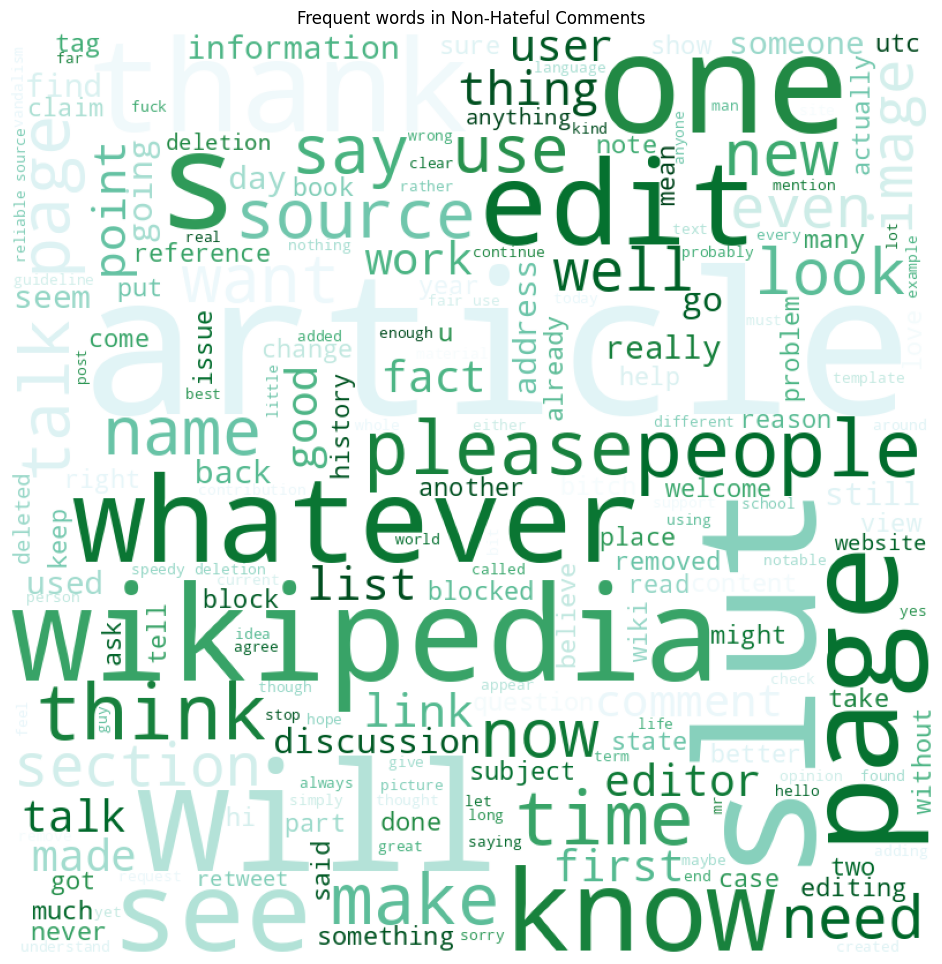

In [ ]:
combined_title = ' '.join(df1['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'BuGn',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Non-Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

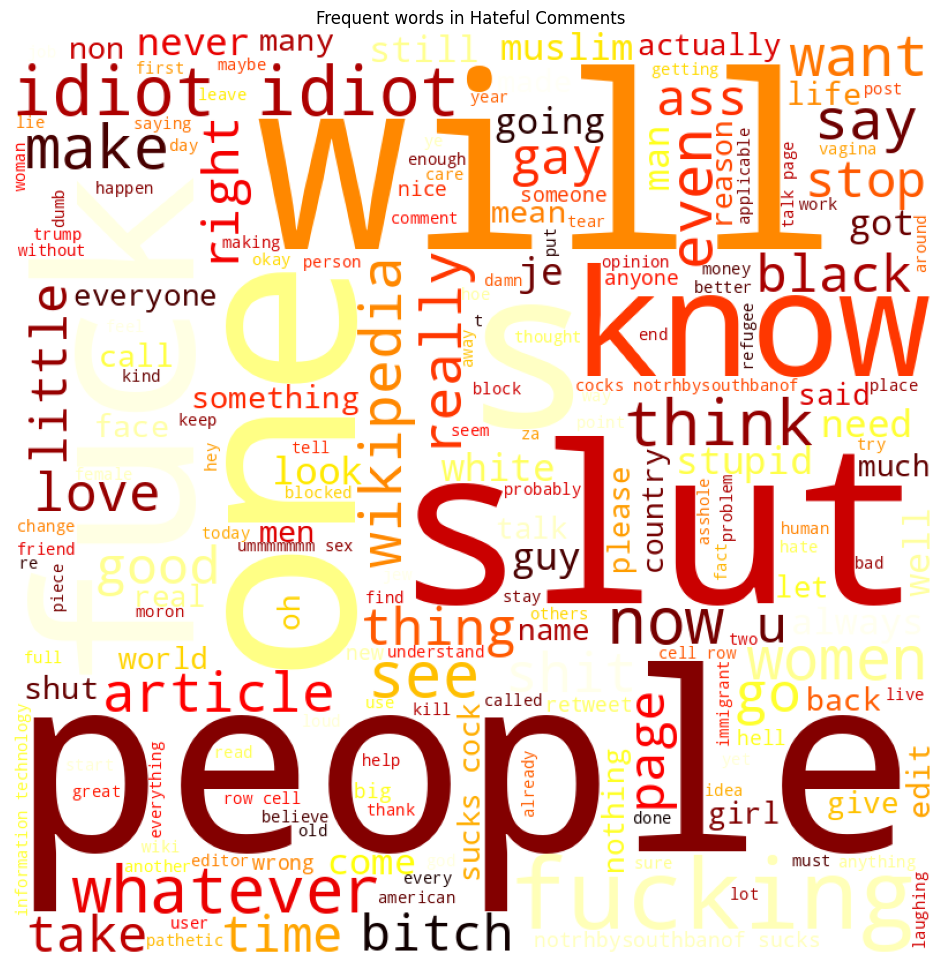

In [ ]:
combined_title = ' '.join(df2['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'hot_r',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

## **Logistic Regression**

### TF IDF

In [ ]:
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet')
    #command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    #subprocess.run(command.split())
    #nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data_tfidf = data.copy()

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Nettoyage des données

In [ ]:
stopwords_l = stopwords.words('english')

punctuation = re.compile("[" + re.escape(string.punctuation) + "]")

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') #Snowball stemmer initialised

def text_cleaning(text, mode="stemming"):
    res = []
    text_clean = re.sub(punctuation,'',text)
    tokens = word_tokenize(text_clean)

    for token in tokens:
        if token.lower() not in stopwords_l:
            if mode == "stemming":
                prepared_word = stemmer.stem(token)
            else:
                prepared_word = lemmatizer.lemmatize(token)
            res.append(prepared_word)
    return ' '.join(res)

In [ ]:
data_tfidf['cleaned_text'] = data_tfidf['Content'].apply(text_cleaning,mode="lemmatisation")

In [ ]:
data_tfidf.loc[0]['Content']

'funny how a wiki user is talking about non scientific i suggest you look up learn more about anthropology before you accuse me of being nonscientific my information does not come from me but from many europeans americans japanese anthropologists go read that wikipedia and learn the difference between proto mongoloids and neo mongoloids than you shall understand why i have edited that information because it is a fact and it is anthropology and please do not accuse of not giving reference utc'

In [ ]:
data_tfidf.loc[0]['cleaned_text']

'funny wiki user talking non scientific suggest look learn anthropology accuse nonscientific information come many european american japanese anthropologist go read wikipedia learn difference proto mongoloid neo mongoloid shall understand edited information fact anthropology please accuse giving reference utc'

### Split into train and test

In [ ]:
train, test = train_test_split(data_tfidf, test_size=0.3, stratify=data['Label'], random_state=42)

X_train = train['cleaned_text']
y_train = train['Label']

X_test = test['cleaned_text']
y_test = test['Label']

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5600,), (5600,), (2400,), (2400,))

In [ ]:
print(X_train)

6075                          sweetie country want coward
1967    fine date birth also sign comment end response...
5775         whatever houseclean formosan rubbish outside
7900    right whatever know apparent gun control stanc...
909     see reason think dead link vandalism indeed u ...
                              ...                        
3712    scarborough toronto canada hard core hampshire...
2601    uh thread never going find guy picky laughing ...
2596    christopher reeve superman michael keaton batm...
1537    list twelve imam salem dear friend please help...
6384    god make another alien mexico case 24 year old...
Name: cleaned_text, Length: 5600, dtype: object


In [ ]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = tfidf_vectorizer.fit_transform(X_train)

X_test_vect = tfidf_vectorizer.transform(X_test)

In [ ]:
print(tfidf_vectorizer.get_feature_names_out())
print(len(tfidf_vectorizer.get_feature_names_out()))

['10' '100' '102' ... 'zoom' 'zora' 'zounderkites']
14734


In [ ]:
print(X_train_vect)

  (0, 12783)	0.6338229004324131
  (0, 2867)	0.3971793964963483
  (0, 14178)	0.3266337773129153
  (0, 2892)	0.5777780139504589
  (1, 4843)	0.32015915533393646
  (1, 3173)	0.31051464541600104
  (1, 1313)	0.3913467221754747
  (1, 11838)	0.30835006940081106
  (1, 2457)	0.24716732099386046
  (1, 4215)	0.29522574218054987
  (1, 10939)	0.3319039045361087
  (1, 162)	0.2585603877749518
  (1, 11841)	0.3782981223074721
  (1, 7568)	0.2302489039960469
  (1, 7445)	0.17736719387286878
  (2, 6054)	0.5627855397484147
  (2, 5016)	0.5627855397484147
  (2, 11218)	0.45543987721506146
  (2, 9192)	0.39889771965066556
  (3, 11080)	0.25585305756508975
  (3, 7147)	0.22197936844084123
  (3, 593)	0.44838378350574437
  (3, 5629)	0.3615018471764571
  (3, 2754)	0.34997748473945745
  (3, 12356)	0.4554884010751653
  :	:
  (5598, 5109)	0.14292051905909742
  (5598, 9271)	0.09406791986395506
  (5598, 11015)	0.1704301332535867
  (5598, 5844)	0.12948417581329014
  (5598, 12869)	0.10566907772305044
  (5598, 8984)	0.13538564

### Integration du modèle LR

In [ ]:
linear_clf = LogisticRegression()

# train the model with training data processed using TF-IDF
linear_clf.fit(X_train_vect, y_train)

LogisticRegression()

In [ ]:
y_pred_tf_idf = linear_clf.predict(X_test_vect)


report = classification_report(y_test, y_pred_tf_idf)
print(report)

display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 0],
              "Predicted: Hateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))


              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1200
           1       0.76      0.80      0.78      1200

    accuracy                           0.78      2400
   macro avg       0.78      0.78      0.77      2400
weighted avg       0.78      0.78      0.77      2400



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,902,298
Actual: Hateful,242,958


## **BERT**

### Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['Content'], data['Label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
train_text.shape, val_text.shape, test_text.shape

((5600,), (1200,), (1200,))

In [ ]:
print(len(train_text.iloc[99].split()))

7


### Tokenization


<Axes: >

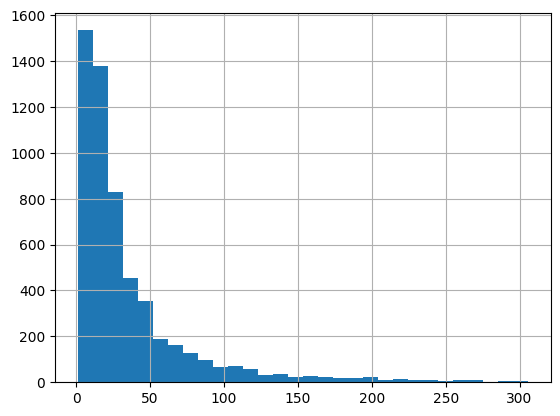

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
seq_len[0]

80

In [ ]:
max_seq_len = 50

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
tokens_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(tokens_train['input_ids'][0])
print(tokens_train['attention_mask'][0])

[101, 3972, 20624, 3070, 1996, 3484, 1997, 1996, 3720, 2434, 2470, 12143, 13433, 2615, 6121, 3608, 2075, 1998, 2062, 2434, 2470, 1996, 3720, 3397, 2074, 2055, 2673, 2008, 2323, 2025, 2022, 1999, 2019, 3720, 1998, 2498, 2008, 2323, 2022, 1999, 2053, 2025, 8010, 2053, 7604, 2053, 2128, 20414, 11656, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print(tokens_train['input_ids'][99])
print(tokens_train['attention_mask'][99])

[101, 2128, 2102, 28394, 2102, 1045, 2031, 2019, 14325, 1997, 7743, 2229, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Utilisation de convert_ids_to_tokens pour obtenir les tokens correspondants
tokens = tokenizer.convert_ids_to_tokens(tokens_train['input_ids'][99])

# Afficher les tokens
print(tokens)

['[CLS]', 're', '##t', '##wee', '##t', 'i', 'have', 'an', 'embarrassment', 'of', 'bitch', '##es', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
print(train_text.iloc[99])

retweet i have an embarrassment of bitches


### Convertir des séquences entières en tenseurs



Cette étape prépare les données encodées pour qu'elles puissent être utilisées avec PyTorch. BERT et d'autres modèles de la bibliothèque transformers fonctionnent avec des tenseurs PyTorch ou TensorFlow.

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

PyTorch travaille avec des Tenseurs (équivalents aux tableaux multidimensionnels) pour gérer les données d’entrée.

### Créer des DataLoaders

Le DataLoader permet de charger efficacement les données par lot (batch) pendant l'entraînement et la validation, ce qui améliore les performances du modèle.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

#wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

#sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during testing
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

### Définir l'architecture du modèle

In [ ]:
# Define BERT classifier
class BERTClassifier(nn.Module):

    def __init__(self):

        # Specify network layers
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        self.linear = nn.Linear(self.bert.config.hidden_size, 1)

        # Define dropout
        self.dropout = nn.Dropout(0.3)  # Augmenté à 0.3 pour plus de régularisation

        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = True

    def forward(self, text, masks):
        #output_bert = self.bert(text, attention_mask=masks).last_hidden_state.mean(axis=1)
        #print(output_bert.last_hidden_state)
        #print(self.bert.config.hidden_size)

        output_bert = self.bert(text, attention_mask=masks).last_hidden_state
        output_bert = self.avg_pool(output_bert.transpose(1, 2)).squeeze(-1)

        return self.linear(self.dropout(output_bert))

### Définir la fonction de perte

BCEWithLogitsLoss : Évite les erreurs de sous-flux (underflow) et de débordement (overflow) que l’on pourrait avoir en séparant la sigmoïde et la cross-entropy.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

### Définir l’optimiseur

Adam : Particulièrement utile pour les modèles complexes comme BERT. Il s'adapte au gradient de chaque paramètre, ce qui est plus efficace que le SGD standard.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BERTClassifier()

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### la boucle d'entraînement et de validation


In [ ]:
model.to(device)

val_losses = []
train_losses = []

best_val_loss = float('inf')
# Train model
for epoch_i in range(0, 10):

    # ========================================
    #               Training
    # ========================================

    model.train()
    print(f"Start training epoch {epoch_i}...")
    total_train_loss = 0
    for i, batch in enumerate(tqdm(train_dataloader)):

        optimizer.zero_grad()

        input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
        masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
        label = torch.tensor(batch[2]).to(device)

        output = model(input_ids, masks)
        loss = criterion(output.squeeze(), label.float())

        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients".
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    # ========================================
    #               Validation
    # ========================================

    model.eval()
    print("Start validation...")
    y_true_bert = list()
    y_pred_bert = list()

    total_eval_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
            masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
            label = torch.tensor(batch[2]).to(device)

            output = model(input_ids , masks)
            max_output = (torch.sigmoid(output).cpu().numpy().reshape(-1)>= 0.5).astype(int)
            y_true_bert.extend(label.tolist())
            y_pred_bert.extend(max_output.tolist())

            loss_v = criterion(output.squeeze(), label.float())
            total_eval_loss += loss.item()
    avg_val_loss = total_eval_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Metrics after Epoch {epoch_i}")
    print(f"Accuracy : {accuracy_score(y_true_bert, y_pred_bert)}")
    print(f"Presision: {np.round(precision_score(y_true_bert, y_pred_bert),3)}")
    print(f"Recall: {np.round(recall_score(y_true_bert, y_pred_bert),3)}")
    print(f"F1: {np.round(f1_score(y_true_bert, y_pred_bert),3)}")
    print("   ")

    # ========================================
    #       Enregistrement du Meilleur Modèle
    # ========================================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch_i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, "best_bert_model.pt")
        print(f"Best model saved at epoch {epoch_i + 1} with validation loss {avg_val_loss:.2f}")

Start training epoch 0...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 0
Accuracy : 0.8066666666666666
Presision: 0.813
Recall: 0.797
F1: 0.805
   
Best model saved at epoch 1 with validation loss 0.50
Start training epoch 1...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 1
Accuracy : 0.8166666666666667
Presision: 0.835
Recall: 0.79
F1: 0.812
   
Best model saved at epoch 2 with validation loss 0.36
Start training epoch 2...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 2
Accuracy : 0.8058333333333333
Presision: 0.855
Recall: 0.737
F1: 0.791
   
Best model saved at epoch 3 with validation loss 0.11
Start training epoch 3...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 3
Accuracy : 0.7808333333333334
Presision: 0.872
Recall: 0.658
F1: 0.75
   
Start training epoch 4...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 4
Accuracy : 0.8191666666666667
Presision: 0.843
Recall: 0.785
F1: 0.813
   
Best model saved at epoch 5 with validation loss 0.02
Start training epoch 5...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 5
Accuracy : 0.8191666666666667
Presision: 0.838
Recall: 0.792
F1: 0.814
   
Start training epoch 6...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 6
Accuracy : 0.81
Presision: 0.836
Recall: 0.772
F1: 0.802
   
Best model saved at epoch 7 with validation loss 0.00
Start training epoch 7...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 7
Accuracy : 0.8058333333333333
Presision: 0.839
Recall: 0.757
F1: 0.796
   
Best model saved at epoch 8 with validation loss 0.00
Start training epoch 8...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 8
Accuracy : 0.7983333333333333
Presision: 0.839
Recall: 0.738
F1: 0.785
   
Start training epoch 9...


  0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-47-f30e8fcdfd12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch[0]).to(device)  # Assurez-vous que batch[0] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(batch[1]).to(device)      # Assurez-vous que batch[1] est bien un tenseur
<ipython-input-47-f30e8fcdfd12>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2]).to(device)
100%|██████████| 175/175 [0

Start validation...
Metrics after Epoch 9
Accuracy : 0.8241666666666667
Presision: 0.853
Recall: 0.783
F1: 0.817
   


### Evaluation du modèle

In [ ]:
print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_bert, y_pred_bert)))
print('\nClassification report: \n', classification_report(y_true_bert, y_pred_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 0],
              "Predicted: Hateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Test accuracy: 0.82

Classification report: 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       600
           1       0.85      0.78      0.82       600

    accuracy                           0.82      1200
   macro avg       0.83      0.82      0.82      1200
weighted avg       0.83      0.82      0.82      1200


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,519,81
Actual: Hateful,130,470


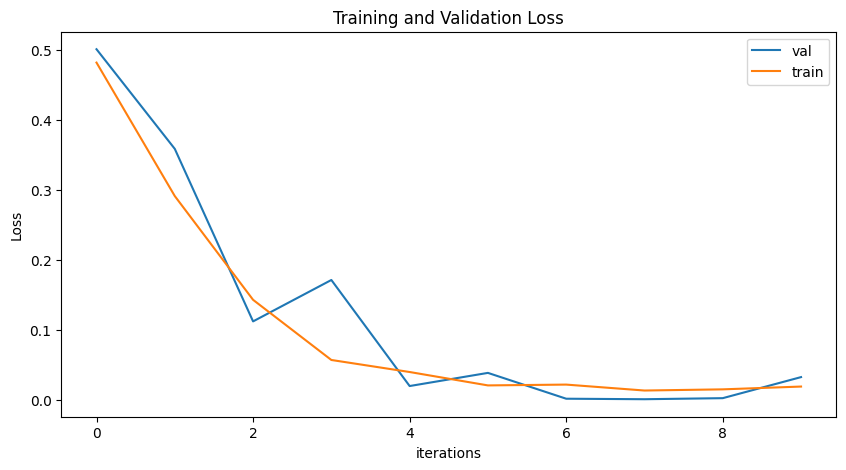

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Évaluation sur l’ensemble de Test

In [ ]:
path="best_bert_model.pt"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-65-09ef6abbd14d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


<All keys matched successfully>

Test Accuracy: 0.82
Test Precision: 0.86
Test Recall: 0.77
Test F1 Score: 0.81

Test Confusion Matrix:
 [[522  78]
 [138 462]]


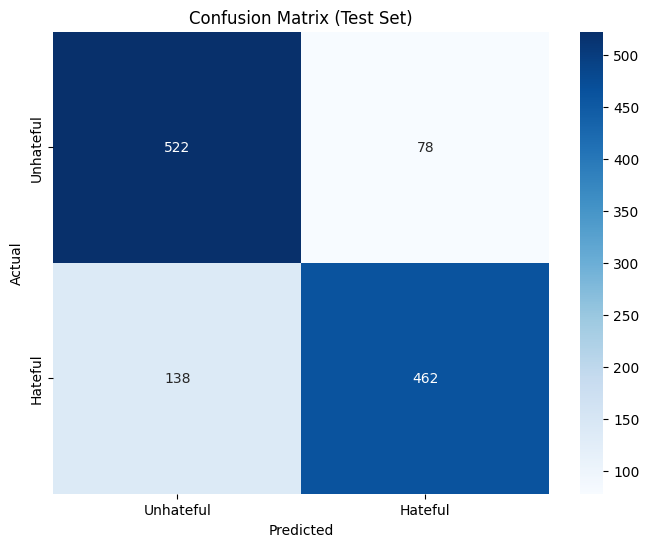

In [ ]:
# Assurez-vous que votre modèle est en mode évaluation
model.eval()

y_true_test = []
y_pred_test = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        masks = batch[1].to(device)
        labels = batch[2].to(device)

        # Obtenez les prédictions
        outputs = model(input_ids, masks)
        predicted_labels = (torch.sigmoid(outputs).cpu().numpy().reshape(-1) >= 0.5).astype(int)

        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted_labels)

# Calcul des métriques sur l'ensemble de test
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = f1_score(y_true_test, y_pred_test)

# Affichage des résultats
print(f"Test Accuracy: {accuracy_test:.2f}")
print(f"Test Precision: {precision_test:.2f}")
print(f"Test Recall: {recall_test:.2f}")
print(f"Test F1 Score: {f1_test:.2f}")

# Matrice de confusion pour l'ensemble de test
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print("\nTest Confusion Matrix:\n", conf_matrix_test)

# Optionnel: Visualisation de la matrice de confusion pour l'ensemble de test
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Unhateful', 'Hateful'], yticklabels=['Unhateful', 'Hateful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()


## **Déploiement**

In [ ]:
import gradio as gr
import torch
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Assure-toi d'utiliser le même tokenizer

# Mode évaluation pour le modèle
model.eval()

# Fonction de prédiction
def predict_hate_speech(text):
    # Prétraitement du texte : tokenisation
    inputs = tokenizer(text, return_tensors="pt", max_length=50, truncation=True, padding="max_length")
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Prédiction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask).squeeze(0)
        prob = torch.sigmoid(outputs).item()

    # Résultat : Hateful ou Unhateful
    if prob >= 0.5:
        return "Hateful Speech"
    else:
        return "Unhateful Speech"

# Interface Gradio
interface = gr.Interface(
    fn=predict_hate_speech,  # Fonction de prédiction
    inputs=gr.Textbox(lines=3, placeholder="Entrez un texte..."),  # Entrée : champ de texte
    outputs=[gr.Textbox(label="Résultat")],  # Sorties : résultat et probabilité
    title="Détection de discours haineux",
    description="Entrez un texte pour prédire s'il est haineux ou non.",
)

# Lancer l'interface
interface.launch()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://01bb2ca9e4a16963c6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **Conclusion**
Ce projet de détection de discours haineux met en avant l’importance de l’intelligence artificielle et du traitement du langage naturel dans la lutte contre les contenus nuisibles en ligne. En utilisant le modèle BERT, nous avons pu construire un système capable de détecter automatiquement les discours haineux avec un haut niveau de précision.

En conclusion, ce projet constitue une première étape vers une modération automatisée plus efficace, contribuant à la construction d’environnements en ligne plus sûrs et respectueux. Le modèle proposé peut être affiné davantage et déployé à plus grande échelle, offrant un potentiel d'impact significatif pour les plateformes en ligne et les réseaux sociaux, où la modération rapide et fiable est primordiale.